# Approach 4 - Autoencoder (architecture 2)

In [7]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from py.PyTorchData import get_log, create_dataloader, model_output_to_image
from py.Autoencoder2 import Autoencoder
from py.Dataset import Dataset
from py.Labels import LABELS
from py.ImageUtils import display_images

DIR = '/home/kleinsteuber/vscode/ResizedSessions256_NoBackup' # dataset directory

ds = Dataset(DIR)
session = ds.create_session("beaver_01")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found 1 sessions
Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions256_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


In [2]:
from torchinfo import summary
summary(Autoencoder(), (32, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [32, 3, 256, 256]         --
├─Sequential: 1-1                        [32, 64, 4, 4]            --
│    └─Conv2d: 2-1                       [32, 128, 64, 64]         18,944
│    └─ReLU: 2-2                         [32, 128, 64, 64]         --
│    └─Conv2d: 2-3                       [32, 64, 32, 32]          73,792
│    └─ReLU: 2-4                         [32, 64, 32, 32]          --
│    └─Conv2d: 2-5                       [32, 32, 16, 16]          18,464
│    └─ReLU: 2-6                         [32, 32, 16, 16]          --
│    └─Conv2d: 2-7                       [32, 64, 8, 8]            18,496
│    └─ReLU: 2-8                         [32, 64, 8, 8]            --
│    └─Conv2d: 2-9                       [32, 128, 4, 4]           73,856
│    └─ReLU: 2-10                        [32, 128, 4, 4]           --
│    └─Conv2d: 2-11                      [32, 64, 4, 4]          

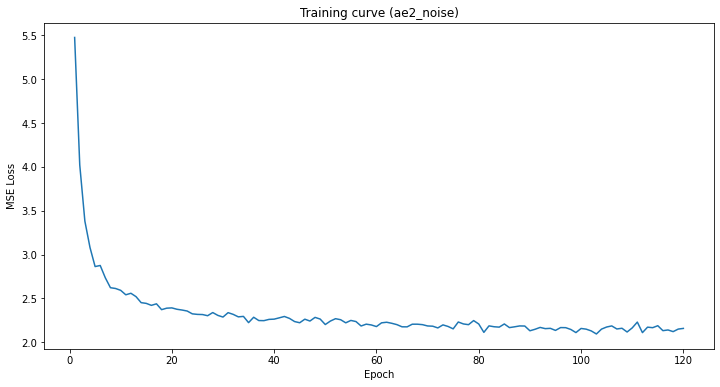

In [25]:
its, losses = get_log("ae2_noise", display=True)

In [26]:
model = Autoencoder()
model.load_state_dict(torch.load("./ae_train_NoBackup/ae2_noise/model_120.pth", map_location=torch.device("cpu")))
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 128, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (11): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU

In [27]:
def labeler(filename: str) -> int:
    is_normal = (int(filename[10:-4]) in LABELS["Beaver_01"]["normal"])
    return 0 if is_normal else 1

test_dl = create_dataloader(session.get_motion_folder(), shuffle=False, labeler=labeler, skip_transforms=True)

In [28]:
features, labels = next(iter(test_dl))
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")
input_imgs = model_output_to_image(features).detach()
output_imgs = model_output_to_image(model(features)).detach()

Feature batch shape: torch.Size([32, 3, 256, 256])
Labels batch shape: torch.Size([32])


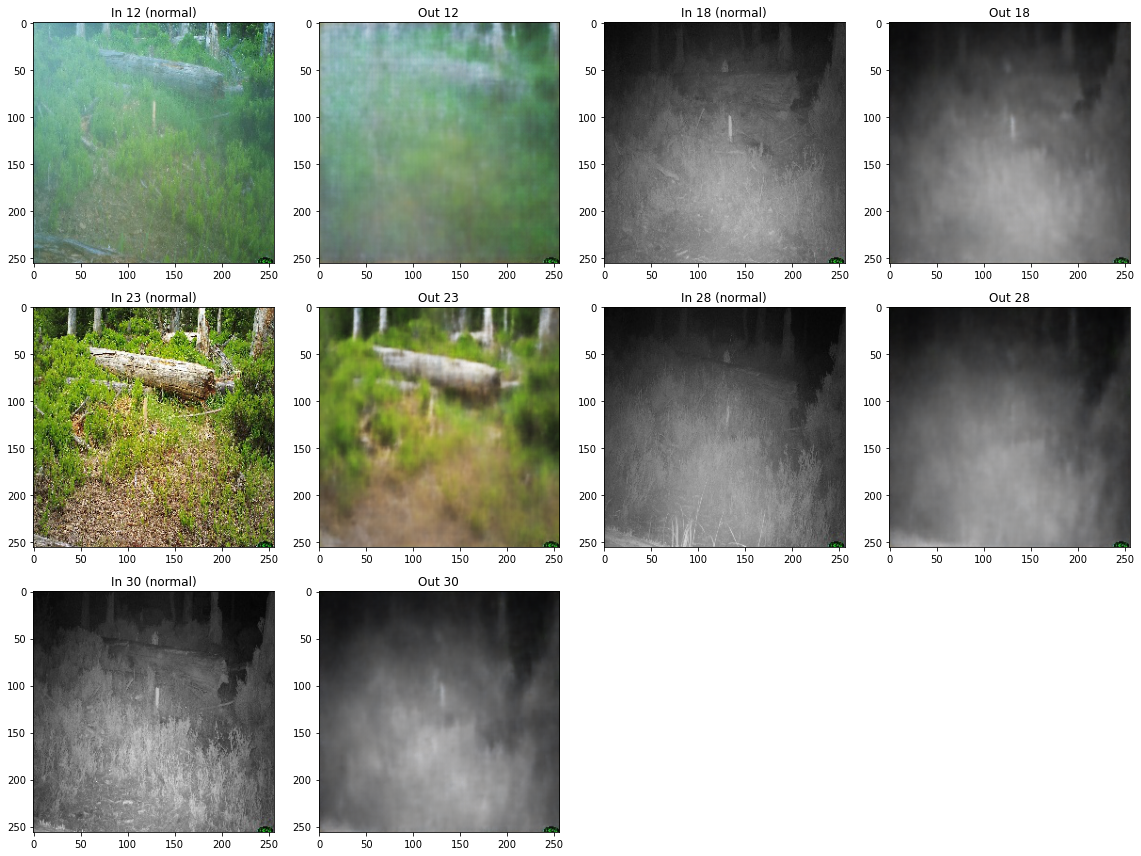

In [29]:
dimgs = []
dlbls = []
for i in range(32):
    if labels[i] == 1:
        continue
    lbl = "anomalous" if labels[i] == 1 else "normal"
    dimgs += [np.einsum("ijk->jki", input_imgs[i]), np.einsum("ijk->jki", output_imgs[i])]
    dlbls += [f"In {i} ({lbl})", f"Out {i}"]
display_images(dimgs, dlbls, size=(4, 4), row_size=4)

In [30]:
criterion = nn.MSELoss()
normal_losses = []
anomalous_losses = []
for features, labels in tqdm(test_dl):
    output_batch = model(features)
    for input, output, label in zip(features, output_batch, labels):
        loss = criterion(input, output)
        if label == 1:
            anomalous_losses.append(loss.item())
        else:
            normal_losses.append(loss.item())

100%|██████████| 22/22 [03:12<00:00,  8.77s/it]


In [31]:
print("Normal avg loss:", np.average(normal_losses))
print("Anomalous avg loss:", np.average(anomalous_losses))

Normal avg loss: 0.0567878704625056
Anomalous avg loss: 0.0582762749677437


In [32]:
from sklearn.linear_model import LogisticRegression

In [33]:
X = np.array(normal_losses + anomalous_losses).reshape(-1, 1) # only one feature
y = np.array(([-1] * len(normal_losses)) + ([1] * len(anomalous_losses)))

clf = LogisticRegression().fit(X, y)
clf.score(X, y)

0.8935251798561151

In [34]:
def eval_test(df_threshold = 0):
    test_results = np.where(clf.decision_function(X) >= df_threshold, np.ones(y.shape[0]), -np.ones(y.shape[0]))

    accuracy = np.mean(test_results == y)
    tar = np.sum((test_results == 1) & (y == 1)) / np.sum(y == 1)
    tnr = np.sum((test_results == -1) & (y == -1)) / np.sum(y == -1)
    far = np.sum((test_results == 1) & (y == -1)) / np.sum(y == -1)
    fnr = np.sum((test_results == -1) & (y == 1)) / np.sum(y == 1)
    precision = (np.sum((test_results == 1) & (y == 1)) / np.sum(test_results == 1)) if np.any(test_results == 1) else 0

    return accuracy, tar, tnr, far, fnr, precision

accuracy, tar, tnr, far, fnr, precision = eval_test()

print(f"Accuracy:                               {accuracy:.3f}")
print(f"True anomalous rate (must be high!):    {tar:.3f} \t - How many animals are detected as animals? (recall)")
print(f"True normal rate (higher is better):    {tnr:.3f} \t - How many empties are detected as empties?")
print(f"False anomalous rate (lower is better): {far:.3f} \t - How many empties are detected as animals?")
print(f"False normal rate (must be low!):       {fnr:.3f} \t - How many animals are detected as empties?")
print(f"Precision (higher is better):           {precision:.3f} \t - How many detected animals are actually animals?")

Accuracy:                               0.894
True anomalous rate (must be high!):    1.000 	 - How many animals are detected as animals? (recall)
True normal rate (higher is better):    0.000 	 - How many empties are detected as empties?
False anomalous rate (lower is better): 1.000 	 - How many empties are detected as animals?
False normal rate (must be low!):       0.000 	 - How many animals are detected as empties?
Precision (higher is better):           0.894 	 - How many detected animals are actually animals?


In [44]:
df_threshold_range = (2.12, 2.15, 0.00002)
num_points = len(np.arange(*df_threshold_range))
print(f"{num_points} points")
eval_results = np.empty((num_points, 7))

for i, df_threshold in tqdm(enumerate(np.arange(*df_threshold_range))):
    metrics = eval_test(df_threshold)
    eval_results[i] = [df_threshold, *metrics]

1500 points


1500it [00:00, 2515.87it/s]


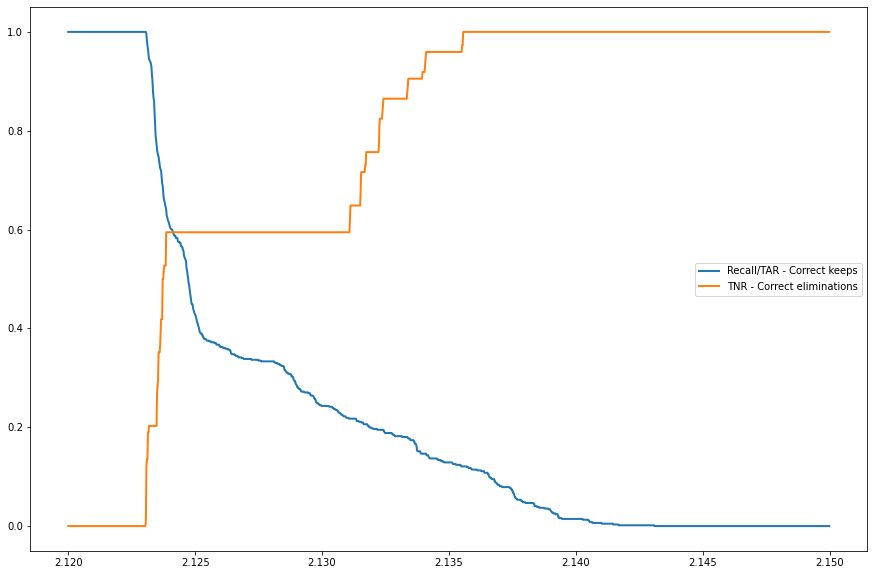

In [45]:
metrics_names = ["Accuracy", "Recall/TAR - Correct keeps", "TNR - Correct eliminations", "FAR", "FNR", "Precision"]
enable_metrics = [1, 2]
plt.figure(figsize=(15, 10))
for i, metrics_name in enumerate(metrics_names):
    if i in enable_metrics:
        plt.plot(eval_results[:,0], eval_results[:,(i+1)], label=metrics_name, linewidth=2)
plt.legend()
plt.show()

In [47]:
i = 0
while eval_results[i,2] >= 0.95:
    i += 1
print(f"threshold = {eval_results[i,0]}, recall = {eval_results[i,2]}, tnr = {eval_results[i,3]}")

threshold = 2.123180000000021, recall = 0.9452495974235104, tnr = 0.20270270270270271
